In [1]:
# 1

########## 20 November 2018 - Alec S. Hirschauer ##########
# Today I am making a K vs J-K CMD for NGC 6822 using Python
# drawing from the Khan et al. (2015) Spitzer data set
# matched with the Sibbons et al. (2012) WFCAM/UKIRT data set.
#
# I will be implementing histograms binned by K-magnitude
# in effort to isolate where in J-K color space we should be
# placing boundaries for segregating oxygen-rich AGB stars
# from carbon-rich AGB stars.
#
# Typical values for these vertical lines are at (about):
# J-K = 0.7 (separating foreground stars from M-type/O-rich AGBS)
# J-K = 1.2 (separating M-type/O-rich AGBs from C-type/C-rich AGBs)
#
# While vertical separation lines are useful, Libby Jones is
# in favor of diagonal boundaries, which better follow the shape
# of the structure of AGB star points on the CMDs themselves.
#
# One way to investigate this is a technique Martha Boyer suggested
# from a paper by Rosenfield et al. (2016), which basically takes
# histograms as described above, but in small increments of y-axis
# (say, 0.1 magnitudes wide) to determine what the slope would be.
#
# This Python notebook will only deal with the K vs J-K CMD, but
# future notebooks will investigate other relevant CMDs and colors
# which will also be useful in identifying AGB star candidates.
#________________
#
# As of 12 November 2018, Owen Boberg has helped me with estimating
# the histogram inflection points using Gaussian KDEs.
#________________
#
# As of 20 November 2018, I will optimize both horizontal (J-K) and
# vertical (K-band) binwidths, rather than selecting arbitrary ones,
# in effort to account for statistical Poisson uncertainties in the
# photometry that I am using.
#
# In particular, the vertical bin width has to be appreciably better
# than the photometric uncertainties (maybe 5-sigma?).
#
# Also, I will identify not just the C-rich/M-type AGB star candidates
# and the O-rich/O-type AGB star candidates, but also the extremely
# dusty sources way redward on the plot *and* a small branch at about
# J-K = 1.0 that Libby saw which could represent the first dusty track
# of O-rich AGB stars.
#
# NB: I still need the horizontal TRGB boundary from Libby, which for now
# is set as K=17.1, from the Sibbons+ study (which uses K_s, not K).
#
# In principle, I should determine where the vertical bins start based
# off of this number.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
#
# After comparing cells where I made CMDs with the "filter_phot_data" data and with
# the specific colors' information above, I have found that they are the same!
# I will use these data instead of calling from the larger catalog.
#
# These two were made following a meeting with Margaret on 2 October 2018.
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
#
# NB: the bin width routine Libby sent me had previously produced values that were
# clearly too big, which is probably due to "NULL" or "-9999" values in the inputs.

In [5]:
# 5

# The first thing I'll do here is make the J vs J-K CMD & Hess diagram.

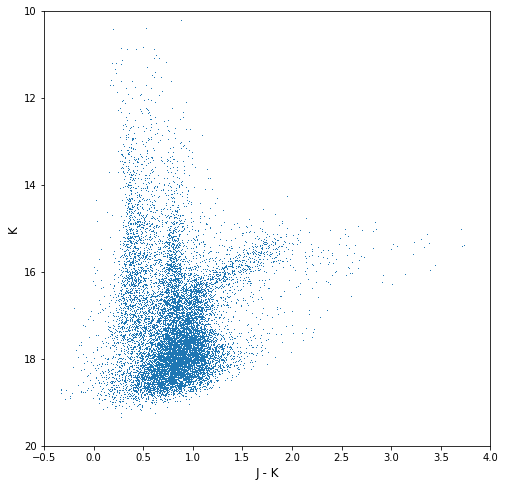

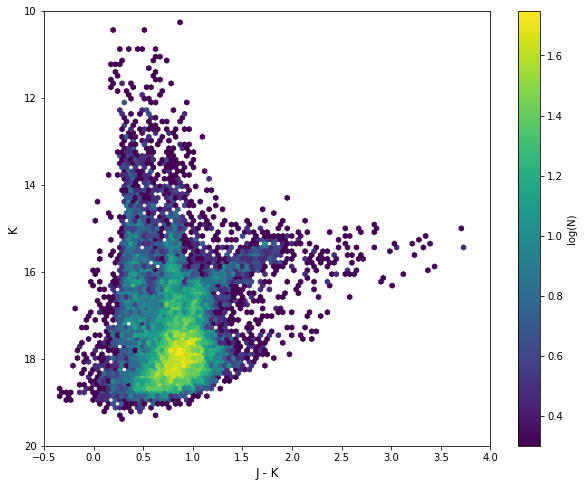

In [19]:
# 6

# K vs J-K
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#plt.savefig('K_vs_J-K_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
im1 = ax1.hexbin(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5, 4.0, 20.0, 10.0))
ax1.set_xlabel('J - K', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('K_vs_J-K_hist.pdf')

In [7]:
# 7

# The second thing I'll do is make the first histogram, which uses all the data
# (no restriction in K-band), so it's basically one big lump.
#________________
#
# I am going to try using Libby Jones' optimum bin width routine here rather than
# manually setting semi-arbitrary bin widths as I had done before, but with an
# expectation that the values should be more or less the same.

0.12653999999999999
95.85538169748698
0.13349999999999973
145.9513108614235


/Users/ahirschauer/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


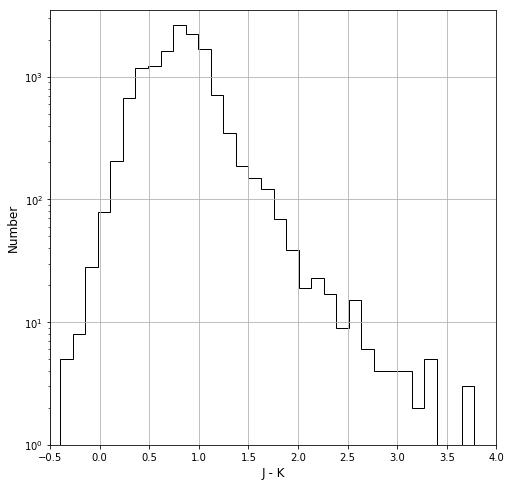

In [8]:
# 8

# J-K
# histogram
#
# these are the horizontal (J-K) bins
#binwidth = 0.1
binwidth = (stats.knuth_bin_width(jMINUSkDATA.jMINUSk))
bin_number = (max(jMINUSkDATA.jMINUSk)+binwidth)/binwidth
#
print binwidth
print bin_number
#
# these are the vertical (K-band) bins
#binwidth2 = 0.25
binwidth2 = (stats.knuth_bin_width(jMINUSkDATA.Kmag))
bin_number2 = (max(jMINUSkDATA.Kmag)+binwidth2)/binwidth2
#
print binwidth2
print bin_number2
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkDATA.jMINUSk, bins=np.arange(min(jMINUSkDATA.jMINUSk), max(jMINUSkDATA.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.ylim(0.0, 3500.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

In [9]:
# 9

# I have implemented Libby's optimum bin width code here to calculate the
# optimum bin width (duh) in both the horizontal (J-K) direction and vertical
# (K-band) direction.
#
# By specifying the correct input file, I got it to work!  Fancy that.
#
# With optimum bin withs rather than semi-arbitrarily selected ones, I can
# go ahead and re-do the inflection point local minima analysis from before.
#
# But first I should test to see if these optimum bin width values are variable
# depending on over where in the CMD you are sampling the data.  My guess is "yes".
#________________
#
# The third thing I'll do is make a different histogram with a restricted
# K-band range, to illustrate how isolating some data can help bring out
# the details of the CMD.
#
# For a start, I'll only plot K-values between 14.0 and 16.0.

0.10433043478260869
116.04792465410904
0.11741176470588321
137.26402805611121


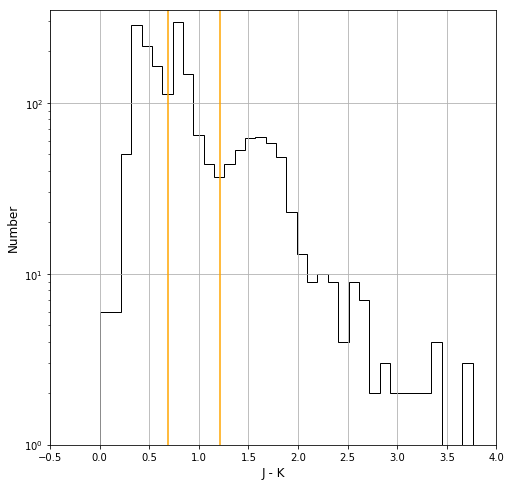

In [10]:
# 10

# J-K
# histogram (where phot_data.Kmag = 14.0 to 16.0)
#
jMINUSkHIST0 = jMINUSkDATA[(jMINUSkDATA.Kmag < 16.0) & (jMINUSkDATA.Kmag > 14.0)]
#
#print jMINUSkHIST.Kmag
#print jMINUSkHIST.jMINUSk
#
# these are the horizontal (J-K) bins
#binwidth = 0.1
binwidth = (stats.knuth_bin_width(jMINUSkHIST0.jMINUSk))
bin_number = (max(jMINUSkHIST0.jMINUSk)+binwidth)/binwidth
#
print binwidth
print bin_number
#
# these are the vertical (K-band) bins
#binwidth2 = 0.25
binwidth2 = (stats.knuth_bin_width(jMINUSkHIST0.Kmag))
bin_number2 = (max(jMINUSkHIST0.Kmag)+binwidth2)/binwidth2
#
print binwidth2
print bin_number2
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST0.jMINUSk, bins=np.arange(min(jMINUSkHIST0.jMINUSk), max(jMINUSkHIST0.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlim(-0.5, 4.0)
plt.ylim(0.0, 350.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.axvline(x=0.69, linewidth=1.5, color='orange') # left inflection point *estimate*
plt.axvline(x=1.21, linewidth=1.5, color='orange') # right inflection point *estimate*
plt.grid(True)
plt.show()
plt.close()

In [11]:
# 11

# As you can see, the inflection points are at roughly
# J-K = 0.7 and J-K = 1.2.
#________________
#
# update (7 Nov 2018): set above as J-K = 0.69 and J-K = 1.21.
# I still haven't implemented Libby's binwidth command, though.
# (e-mailed Libby 9 Nov 2018)
#________________
#
# update (20 Nov 2018): I got the optimum bin width stuff figured
# out, and the orange lines seem to work really well!
#
# Also note that the optimum vertical bin width calculation for
# *all* points = 0.133, while for K = 14.0 to 16.0, it's = 0.117.
#
# These are smaller than my earlier 0.25 dex wide bins, which I
# already thought might be too small.
#________________
#
# I'd like to implement some analysis tool that will figure out
# what that value is to more precision, but also, I'll next make
# progressive histograms which use a more restricted K-band range
# to see where these inflection points will be up the CMD.
#
# ^ Owen Boberg is going to help me out with that.
# update (12 Nov 2013): he did!

In [12]:
# 12

# Rather than estimate where the inflection points are over any
# given range of CMD y-values (in this case, K-band), I'm going to
# fit the histogram with a curve, then determine where the inflection
# points are, indicating the position of local minima.
#
# The following are a series of commands that Owen Boberg showed me
# to create the histogram fit curve.
#
# My intention is to recreate this curve for every y-value range bin
# to determine where the color-cut x-value is, then fit a line to these
# values in order to make a slanted color-cut for AGB star identification.

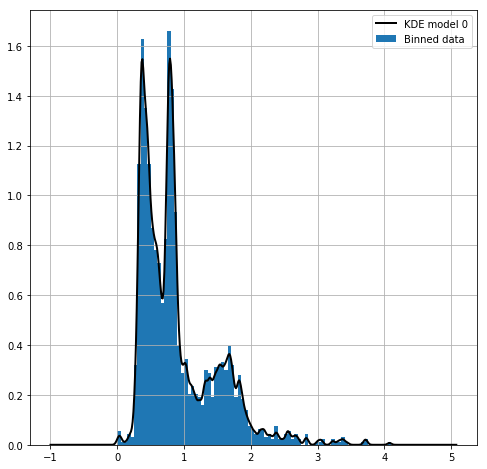

In [25]:
# 13

# Here's the conglomerated series of commands that Owen used to make a
# curve to fit the histogram(s).

kde_data0 = jMINUSkHIST0.jMINUSk[(jMINUSkHIST0.jMINUSk > -100.0) & (jMINUSkHIST0.jMINUSk < 5.0)].values

# ^ This defines the range of data to be used for the Kernel Density Estimation (KDE).
# "kde_data" will be appended with "_#" for successive y-value bin ranges.
#
# NB: I think these cuts are superfluous, since the input files are already culled of 'null' values,
# but I remember Owen saying something about how it's important for the Gaussian fitting?
# For now the cut is greater than -100.0 and less than 5.0 (formerly 3.0).
#
# Since I want to identify the extremely dusty things out past J-K = 3.0, I need to keep
# those data so that I can define minima out 

bins=np.arange(min(kde_data0 ), max(kde_data0 ) + 0.05, 0.05)

# ^ This defines the bins over which the KDE will be plotted.

#kde = gaussian_kde(kde_data,bw_method=0.05)
#or kde = gaussian_kde(kde_data)

# ^ This defines the KDE as a Gaussian to be evaluated over the range of data defined earlier,
# with either binwidths of 0.05 (top) or calculated by the routine and not set manually.

#plt.hist(kde_data,normed=True,bins=bins)

# ^ This plots the KDE estimate for the histogram (linear, not log, which is important).
# In the first plot output, this is the blue histogram; the black line comes later.

x_eval = np.linspace(kde_data0.min() - 1.0, kde_data0.max() + 1.0, 500)

# ^ This evaluates the x-values of the histogram(?), with the KDE minimum and KDE maximum
# as arguments, though I don't fully understand the trailing "500" (or the +/- 1.0s).

#plt.plot(x_eval, kde(x_eval), 'k-')
#plt.xlim(0.60, 0.75)
#plt.ylim(0.5, 0.7)
#plt.grid(True)

# ^ This plots the black line over the blue histogram in the first output plot.

#from scipy.optimize import curve_fit
#from scipy.optimize import leastsq

# ^ These call some fitting algorithms that we didn't end up using, so this could be skipped.

kde_0 = gaussian_kde(kde_data0,bw_method=0.05)
# kde_0 = gaussian_kde(kde_data_0)

# ^ This defines a KDE as a Gaussian to be evaluated over the range of data defined earlier,
# with binwidths of 0.1, very similarly to the third command from the top.

#kde_0.scotts_factor()

# ^ This prints out the value of the KDE, which I think is effectively the binwidth.

plt.figure(figsize=(8,8))
plt.plot(x_eval, kde_0(x_eval),'k',lw=2,label='KDE model 0')
plt.hist(kde_data0,bins=bins,normed=True,label='Binned data')
#plt.xlim(0.6, 0.75)
#plt.ylim(0.5, 0.8)
#plt.xlim(1.15, 1.3)
#plt.ylim(0.16, 0.22)
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# ^ This plots the fit to the second histogram, giving a looser value of the inflection
# points and therefore the local minima as compared to the first histogram, but by not
# following so many of the nooks and crannies, it might do a better job of characterizing
# where to set the color cuts, especially since this doesn't *need* to be too rigorous.
#
# I commented out everything for the first histogram, so I can just use what's left for
# the "mass production" of fit curves for each swathe.
#
# The next step would be to calculate the local minima somehow OR simply zoom in to where
# the minima are and estimate the J-K value to some precision (hundreth's place?).
#
### with binwidth = 0.10, J-K = 0.65, J-K = 1.22
### with binwidth = 0.05, J-K = 0.68, J-K = 1.26* (double minimum)